In [445]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import scipy.stats
import statsmodels.api as sm

In [446]:
# Load the dataset
df = pd.read_csv('/Users/mabuhannood/Downloads/Project/Orders_Cleaned.csv')

- Label Encoding for Categorical Variables 

In [447]:
# Encode categorical variables in selected features
categorical_columns = ['Sales Order Name','Memo', 'Parent Record', 'Sales Region', 'Project Use Type']
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    df[col] = label_encoders[col].fit_transform(df[col])

- Feature Extraction

In [448]:
# Extract features and target
X = df[['Rolls Ordered', 'Est. Extended Cost (Line)', 'Parent Record', 'Actual Ship Date Year', 'Sales Order Name', 'Date Created Year', 'Sales Region', 'Memo', 'Project Use Type']]
y = df['Order Amount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Models Comparison

- Training and Evaluating different models for Regression 

In [449]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

# Display results directly
print("Regression Model Comparison Results:")
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")

Regression Model Comparison Results:

Model: Linear Regression
  MAE: 1807.1531
  MSE: 8785806.2602
  R2: 0.9092

Model: Random Forest
  MAE: 1086.3059
  MSE: 5165164.7231
  R2: 0.9466

Model: Gradient Boosting
  MAE: 1182.9961
  MSE: 5719705.8784
  R2: 0.9409

Model: XGBoost
  MAE: 1032.5105
  MSE: 5137553.9725
  R2: 0.9469


Random Forest is very close to XGBoost but its preferred because its faster and more computational efficient

### Random Forest model

- Hyperparameter Optimization Using Grid Search with Gradient Boosting

In [450]:
# Define the pipeline with a scaler and the Random Forest model
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(random_state=42))
])

# Define hyperparameters for tuning
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print best parameters and score
print("Best Parameters:", best_params)
print("Best Cross-Validated R² Score:", best_score)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best Parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best Cross-Validated R² Score: 0.8756931626990413


- Model Evaluation

In [451]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Hyperparameters:")
print(best_params)
print(f"Best Cross-Validated R2 Score: {best_score}")
print("\nModel Performance on Test Data:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

Best Hyperparameters:
{'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best Cross-Validated R2 Score: 0.8756931626990413

Model Performance on Test Data:
MAE: 1078.594774608588
MSE: 5091698.226111551
R2: 0.9473551924618263


### Validation

- Comparing Actual vs Predicted Values

Validation Data (Actual vs Predicted):
        Actual   Predicted
753     114.16     76.2159
582    3312.54   3525.6156
548    3343.77   3587.3191
113       0.00   1083.6898
174   17113.14  17234.8224
420    7860.05   7918.4092
309    6467.20   7121.9348
998   24002.88  27314.8161
413     600.65    666.8586
1054    288.00    445.6401
1170   5175.79   4025.5973
275    1006.39   1075.7725
771    2364.51   2502.4555
1134   2646.72   3088.1031
415   14223.31  13286.0314
478    4673.32   4675.9183
609       0.00    -30.1686
168   10058.71   7112.8723
332     120.53     96.2046
933   37536.48  37472.9824


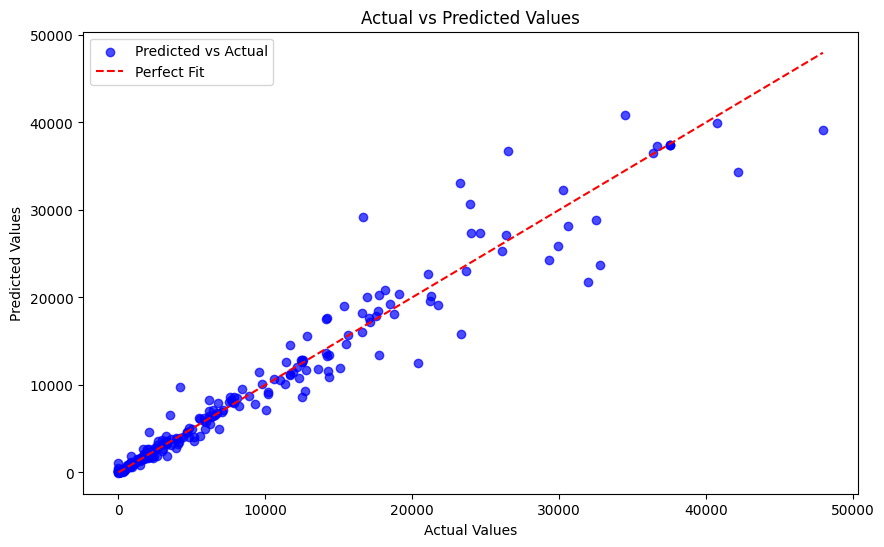

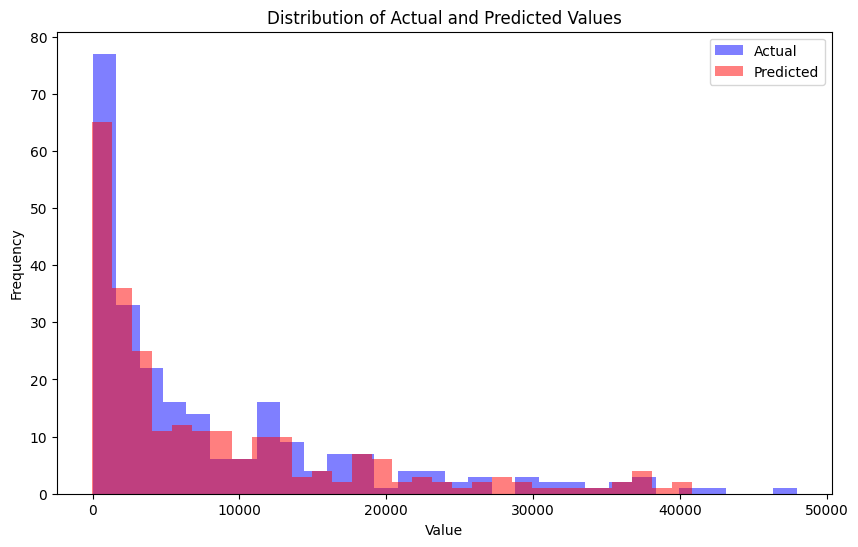

In [454]:
# Create a DataFrame for comparison
validation_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Display a few rows for validation
print("Validation Data (Actual vs Predicted):")
print(validation_df.head(20))

# Plot actual vs predicted (scatter plot)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Fit')  
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

# Plot histogram for actual vs predicted
plt.figure(figsize=(10, 6))
plt.hist(validation_df['Actual'], bins=30, alpha=0.5, label='Actual', color='blue')
plt.hist(validation_df['Predicted'], bins=30, alpha=0.5, label='Predicted', color='red')
plt.title("Distribution of Actual and Predicted Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()



Descriptive Statistics:
             Actual     Predicted
count    247.000000    247.000000
mean    8231.978745   8206.422303
std     9854.497416   9747.412128
min        0.000000    -30.168600
25%     1061.670000   1084.917150
50%     3990.000000   3935.356500
75%    12486.000000  11875.831400
max    47962.430000  40830.858000

P-value for residuals: 0.49549062022664503
                            OLS Regression Results                            
Dep. Variable:           Order Amount   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     289.5
Date:                Thu, 26 Dec 2024   Prob (F-statistic):          1.74e-122
Time:                        09:03:12   Log-Likelihood:                -2314.5
No. Observations:                 247   AIC:                             4649.
Df Residuals:                     237   BIC:                            

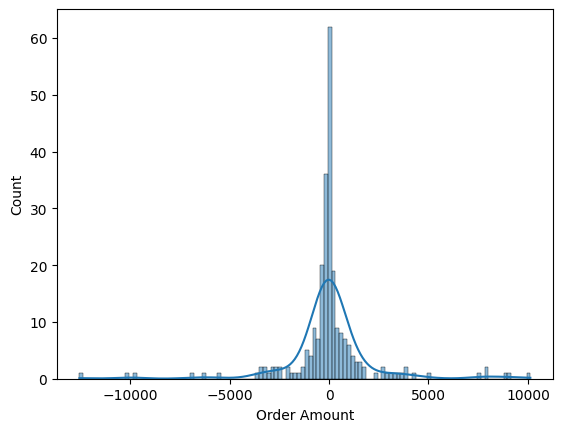

In [455]:
# Stats on actual price & predicted price
print("\nDescriptive Statistics:")
print(validation_df.describe())

# Normality of residual
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)

# Checking p-value for residuals
p_value = scipy.stats.norm.sf(abs(residuals.mean() / residuals.std()))
print(f"\nP-value for residuals: {p_value}")

# OLS Regression Results
X_test_const = sm.add_constant(X_test)
results3 = sm.OLS(y_test, X_test_const).fit()
print(results3.summary())

# Regression confidence
regression_confidence = best_model.score(X_test, y_test)
print(f"\nGradient Boosting Regression Confidence: {regression_confidence}")

- Predicted values closely match actual values, as seen in the scatter plot and histogram.
- Residuals are unbiased and centered around zero.
- Descriptive statistics and results confirm the model's robustness
- Further Investigation can be done to address discrepancies in extreme values to improve predictions.